In [10]:
import cloudknot as ck

In [11]:
ck.set_region('us-east-1')

In [26]:
def afq_prek_api(subject):
    import logging
    import s3fs
    import numpy as np
    import os.path as op
    import os

    import AFQ.api as api
    
    logging.basicConfig(level=logging.INFO)
    log = logging.getLogger(__name__)  

    fs = s3fs.S3FileSystem()
    
    os.mkdir(op.join(op.expanduser('~'), "prek"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}/sess"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}/sess/anat"))
    os.mkdir(op.join(op.expanduser('~'), f"prek/sub{subject}/sess/dwi"))
    os.mkdir(op.join(op.expanduser('~'), f"afq"))
    os.mkdir(op.join(op.expanduser('~'), f"afq/sub{subject}"))
    
    #fs.get(f"prek-diffusion/derivatives/afq/sub{subject}", op.join(op.expanduser('~'), "afq/"), recursive=True)

    dwi_dir = f'prek-diffusion/derivatives/sub-{subject}/dtiInit_ses-pre'
    derivatives_dir_local = op.join(op.expanduser('~'), f"prek/sub{subject}/sess")

    prek_fdata_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.nii.gz")
    prek_fbval_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvals")
    prek_fbvec_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvecs")
    
    prek_fdata = op.join(derivatives_dir_local, f"dwi/dwi_aligned_trilin.nii.gz")
    prek_fbval = op.join(derivatives_dir_local, f"dwi/dwi_aligned_trilin.bvals")
    prek_fbvec = op.join(derivatives_dir_local, f"dwi/dwi_aligned_trilin.bvecs")
    
    fs.get(prek_fdata_src, prek_fdata)
    fs.get(prek_fbval_src, prek_fbval)
    fs.get(prek_fbvec_src, prek_fbvec)

    anat_dir = f'prek-diffusion/derivatives/sub-{subject}/freesurfer/mri'
    fs.get(op.join(anat_dir, f"aparc+aseg.nii.gz"), op.join(derivatives_dir_local, f"anat/aparc+aseg.nii.gz"))

    wm_labels=[250, 251, 252, 253, 254, 255, 41, 2, 16, 77]
    b0_threshold = 50

    tracking_params = {"n_seeds": 2, "directions": 'det', "stop_threshold": 0.2}
    segmentation_params = {"prob_threshold": 10, "b0_threshold": b0_threshold}
    clean_params = {"clean_rounds": 1}

    myafq = api.AFQ(op.join(op.expanduser('~'), f"prek"),
                    dwi_folder="dwi",
                    dwi_file="dwi*",
                    anat_folder="anat",
                    wm_labels=wm_labels,
                    use_xvfbwrapper=True,
                    b0_threshold=b0_threshold,

                    tracking_params=tracking_params,
                    segmentation_params=segmentation_params,
                    clean_params=clean_params)

    myafq.get_template_xform()
    myafq.export_bundles()
    myafq.get_tract_profiles()
    myafq.export_bundle_gif()
    myafq.export_ROI_gifs()
    fs.put(op.join(op.expanduser('~'), "afq"), "prek-diffusion/derivatives", recursive=True)

In [27]:
#afq_prek_api(1110)

In [28]:
afq_knot = ck.Knot(name='afq_prek-64gb-20506-2',
                  func=afq_prek_api,
                  base_image='libglxvfb:1',
                  image_github_installs="https://github.com/36000/pyAFQ.git@xvfb-cloud",
                  pars_policies=('AmazonS3FullAccess',),
                  resource_type="SPOT",
                  bid_percentage=100,
                  memory=64000)

In [29]:
inputs = [1110,
          1112,
          1113]

In [30]:
ft = afq_knot.map(inputs)

In [34]:
afq_knot.view_jobs()

Job ID              Name                        Status   
---------------------------------------------------------
0b6c93cc-71bf-4c05-9f68-8023e2fea438        afq-prek-64gb-20506-2-0        SUCCEEDED


In [10]:
j0 = afq_knot.jobs[0]

In [13]:
j0.status

{'status': 'PENDING',
 'statusReason': None,
 'attempts': [],
 'arrayProperties': {'statusSummary': {'STARTING': 1,
   'FAILED': 0,
   'RUNNING': 18,
   'SUCCEEDED': 0,
   'RUNNABLE': 2,
   'SUBMITTED': 0,
   'PENDING': 0},
  'size': 21}}

In [12]:
afq_knot.clobber()

In [3]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)

try:
    s3.get(f'prek-diffusion/derivatives/AFQ_allvols_rt_ses-pre_19-Nov-2019.mat', 'source.mat')
except FileNotFoundError:
    print(f'mAFQ streamlines not found')
    
# use AFQ browser to process this

In [9]:
for subject in inputs:
    try:
        s3.get(f'prek-diffusion/derivatives/afq/afq/sub{subject}/sess/dwi_aligned_trilin_profiles.csv', f'sub-{subject}_pyAFQ_profiles.csv')
    except FileNotFoundError:
        print(f'subject {subject} streamlines not found')

subject 1113 streamlines not found


In [2]:
import pandas as pd
import numpy as np
profiles_matlab = pd.read_csv('./AFQ-browser/client/data/nodes.csv')

In [3]:
def tract_map(name):
    if name == 'Right Corticospinal':
        return 'CST_R'
    elif name == 'Left Corticospinal':
        return 'CST_L'
    elif name == 'Right Uncinate':
        return 'UNC_R'
    elif name == 'Left Uncinate':
        return 'UNC_L'
    elif name == 'Left IFOF':
        return 'IFO_L'
    elif name == 'Right IFOF':
        return 'IFO_R'
    elif name == 'Right Arcuate':
        return 'ARC_R'
    elif name == 'Left Arcuate':
        return 'ARC_L'
    else:
        return name
        
#profiles_matlab['tractID'].unique()
profiles_matlab['subjectID'] = profiles_matlab['subjectID'].apply(lambda x: pd.to_numeric(x[-4:]))
profiles_matlab['tractID'] = profiles_matlab['tractID'].apply(tract_map)

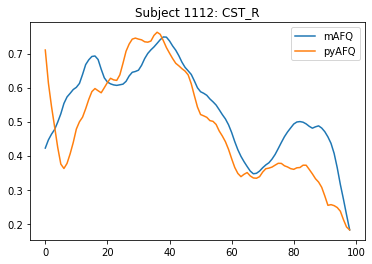

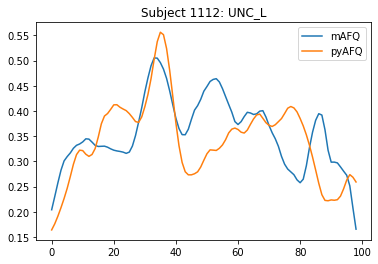

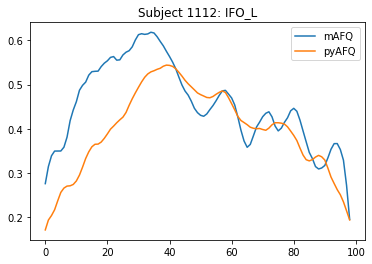

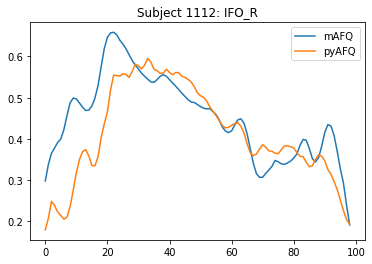

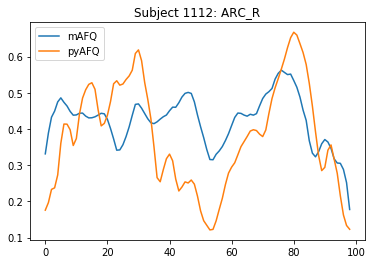

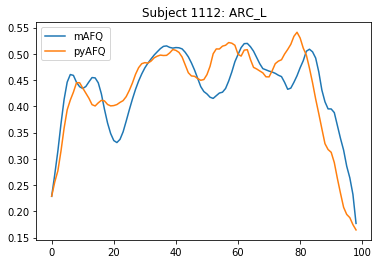

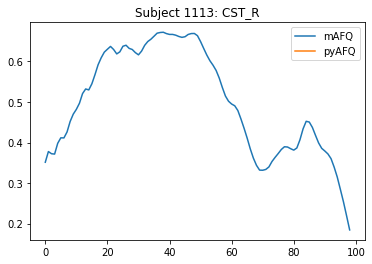

ValueError: operands could not be broadcast together with shapes (0,) (99,) 

In [6]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
bundles = ['CST_R', 'UNC_L', 'IFO_L', 'IFO_R', 'ARC_R', 'ARC_L'] # 'CST_L' 'UNC_R'
subjects = [1112,1113]

percent_diffs = pd.DataFrame(index=bundles, columns=subjects)
for subject in subjects:
    for bundle in bundles:
        profiles_afq = pd.read_csv(f'sub-{subject}_pyAFQ_profiles.csv')

        ml_test = profiles_matlab[(profiles_matlab['subjectID'] == subject) & (profiles_matlab['tractID'] == bundle)]['fa']
        afq_test = profiles_afq[(profiles_afq['scalar'] == 'dti_fa') & (profiles_afq['bundle'] == bundle)]['profiles']
        ml_test = ml_test.to_numpy()[1:]
        afq_test = afq_test.to_numpy()[1:]
        plt.plot(ml_test)
        plt.plot(afq_test)
        plt.title('Subject ' + str(subject) + ': ' + bundle)
        plt.legend(['mAFQ', 'pyAFQ'])
        plt.show()
        
        
        percent_diffs.at[bundle, subject] = np.mean((afq_test - ml_test)/ml_test)

print('Mean Percent Differences')
print(percent_diffs)

In [4]:
print(profiles_matlab['tractID'].unique())
print(profiles_afq['bundle'].unique())

['Left Thalamic Radiation' 'Right Thalamic Radiation' 'CST_L' 'CST_R'
 'Left Cingulum Cingulate' 'Right Cingulum Cingulate'
 'Left Cingulum Hippocampus' 'Right Cingulum Hippocampus'
 'Callosum Forceps Major' 'Callosum Forceps Minor' 'IFO_L' 'IFO_R'
 'Left ILF' 'Right ILF' 'Left SLF' 'Right SLF' 'UNC_L' 'UNC_R' 'ARC_L'
 'ARC_R']


KeyError: 'Bundle'

In [9]:
ml_test = profiles_matlab[(profiles_matlab['subjectID'] == subject) & (profiles_matlab['tractID'] == bundle)]['fa']

In [10]:
ml_test

2300         NaN
2301    0.406386
2302    0.441796
2303    0.471499
2304    0.495186
2305    0.499440
2306    0.489918
2307    0.498059
2308    0.522706
2309    0.547670
2310    0.563576
2311    0.574271
2312    0.584724
2313    0.585748
2314    0.587670
2315    0.582646
2316    0.573634
2317    0.557216
2318    0.545585
2319    0.541261
2320    0.538737
2321    0.534491
2322    0.530308
2323    0.527696
2324    0.537302
2325    0.553245
2326    0.561763
2327    0.564556
2328    0.560319
2329    0.555659
          ...   
2370    0.444613
2371    0.462196
2372    0.481694
2373    0.503084
2374    0.521198
2375    0.534033
2376    0.540955
2377    0.541374
2378    0.536686
2379    0.531270
2380    0.526245
2381    0.523545
2382    0.524835
2383    0.525163
2384    0.523869
2385    0.514359
2386    0.496446
2387    0.477612
2388    0.462474
2389    0.450136
2390    0.435730
2391    0.420324
2392    0.403386
2393    0.385146
2394    0.362250
2395    0.334135
2396    0.301894
2397    0.2642